In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt

_FOLDER = "data/"
_FOLDER_2 = "figures/"
_FOLDER_3 = "results/"
SAVE_FIGURES = False

from filtering import *
from fitting import *

In [2]:
os.listdir(_FOLDER)

['Drug_Features2.csv',
 '.DS_Store',
 'merged_drug_profiles_cells_sigmoid4_123.csv',
 'Cell_Lines_Details.csv',
 'normalised_dose_response_data_GDCS2_EC_conc.csv',
 'Drug_Features.csv',
 'fit_no_filt.csv',
 'Cell_Line_Features_PANCAN_simple_MOBEM.xlsx',
 'Cell_Line_Features_PANCAN_simple_MOBEM.tsv',
 'normalised_dose_response_data.csv']

### Original data

In [3]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")

if "Unnamed: 0" in drug_curves:
    drug_curves.drop("Unnamed: 0", axis=1, inplace =True)

conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

CCL_names = dict(zip(drug_curves["COSMIC_ID"], drug_curves["CELL_LINE_NAME"]))
df= pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_names = dict(zip(df["Drug ID"].values, df["Drug Name"].values))
del df
drug_curves["drug_name"] = drug_curves["DRUG_ID"].map(drug_names)
drug_curves["CCL_name"] = drug_curves["COSMIC_ID"].map(CCL_names)
drug_curves.shape

(225384, 45)

## No filtering but fitting

In [4]:
os.listdir(_FOLDER)

['Drug_Features2.csv',
 '.DS_Store',
 'merged_drug_profiles_cells_sigmoid4_123.csv',
 'Cell_Lines_Details.csv',
 'normalised_dose_response_data_GDCS2_EC_conc.csv',
 'Drug_Features.csv',
 'fit_no_filt.csv',
 'Cell_Line_Features_PANCAN_simple_MOBEM.xlsx',
 'Cell_Line_Features_PANCAN_simple_MOBEM.tsv',
 'normalised_dose_response_data.csv']

In [5]:
no_filt =  pd.read_csv(_FOLDER+ "fit_no_filt.csv", low_memory=False)
no_filt.head()

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,sigmoid_4_param,logistic_4_param_r2,logistic_4_param,ll4_4_param_r2,ll4_4_param,ll4R_4_param_r2,ll4R_4_param,logLogist_3_param_r2,logLogist_3_param,better_fitting
0,HDQ-P1,1290922,332,332_1290922,2,10.240,0,0.111111,0.222222,0.333333,...,NaN,0.200629,[ 1.01921396 122.1436643 1.03320696 4.54...,0.000000,NaN,0.041894,[5.04901419 1.0000574 0.12043141 5.87195241],0.000000,NaN,logistic_4_param
1,HDQ-P1,1290922,257,257_1290922,2,10.240,0,0.111111,0.222222,0.333333,...,[ 1.03531921 0.22800993 -119.00461836 -...,0.878801,[ 1.02263856 126.17305983 1.02388662 -4.55...,0.878801,[ 1.02116897 1.02263857 124.355592 -2.89...,0.878801,[ 3.13276942 1.02263856 129.459316 -5.43...,-0.691860,[-4.65525468e-37 -2.06166515e-01 4.17365848e-01],sigmoid_3_param
2,HDQ-P1,1290922,245,245_1290922,2,40.000,0,0.111111,0.222222,0.333333,...,[ 7.78082352e-01 1.22842472e+00 -1.66577079e+...,0.915344,[ 0.96016016 40.96099914 0.78307545 0.14323275],0.915344,[ 0.78307296 0.96016094 40.9693861 0.14323802],0.915344,[-10.02192963 0.96016083 40.98404476 0.14...,0.905694,[ -0.10877092 -43.84668964 0.14618527],ll4R_4_param
3,HDQ-P1,1290922,155,155_1290922,2,0.512,0,0.111111,0.222222,0.333333,...,[ 0.67329009 2.92401545 -14.80739401 0.75...,0.746528,[1.09381412 9.53441045 0.75318893 0.7297457 ],0.746528,[0.75320905 1.09381076 9.53465065 0.72973134],0.746528,[-2.70236709 1.09381384 9.5343405 0.72974279],-0.096396,[-5.77108460e-32 -2.30114608e-01 4.04935602e-01],ll4R_4_param
4,HDQ-P1,1290922,192,192_1290922,2,16.000,0,0.111111,0.222222,0.333333,...,NaN,0.501660,[ 1.00999302 153.60654931 0.67232851 1.17...,0.501660,[ 0.67339751 1.17703507 -129.2377876 ...,0.501660,[-59.17056572 1.00999302 149.13638503 1.17...,0.496308,[ -0.1724763 -50.75567054 1.17703507],logistic_4_param


In [6]:
functions = [
             "sigmoid_2_param",
             "sigmoid_3_param",
             "sigmoid_4_param",
             "logistic_4_param",
            "ll4_4_param",
            "ll4R_4_param",
            "logLogist_3_param"]

In [7]:
stat =  pd.DataFrame(index =  functions, columns = ["r2>0.9", "r2>0.99"])
for func in stat.index:
    for col in stat.columns:
        r2 = float(col.split(">")[-1])
        stat.loc[func, col] = no_filt[no_filt[func+"_r2"]>= r2].shape[0]
stat

,r2>0.9,r2>0.99
sigmoid_2_param,53063,6612
sigmoid_3_param,70557,11402
sigmoid_4_param,53848,15166
logistic_4_param,73123,16752
ll4_4_param,73155,17082
ll4R_4_param,67847,16614
logLogist_3_param,72883,16215


## Functions of interest are sigmoid_4_param (as in MSc project) and ll4_4_param (max number of fitting)

In [8]:
df_sigm = no_filt[no_filt["sigmoid_4_param_r2"]>=0.99].copy()
df_ll = no_filt[no_filt["ll4_4_param_r2"]>=0.99].copy()
print(df_sigm.shape[0], df_ll.shape[0])

15166 17082


Responses above 1: 4937


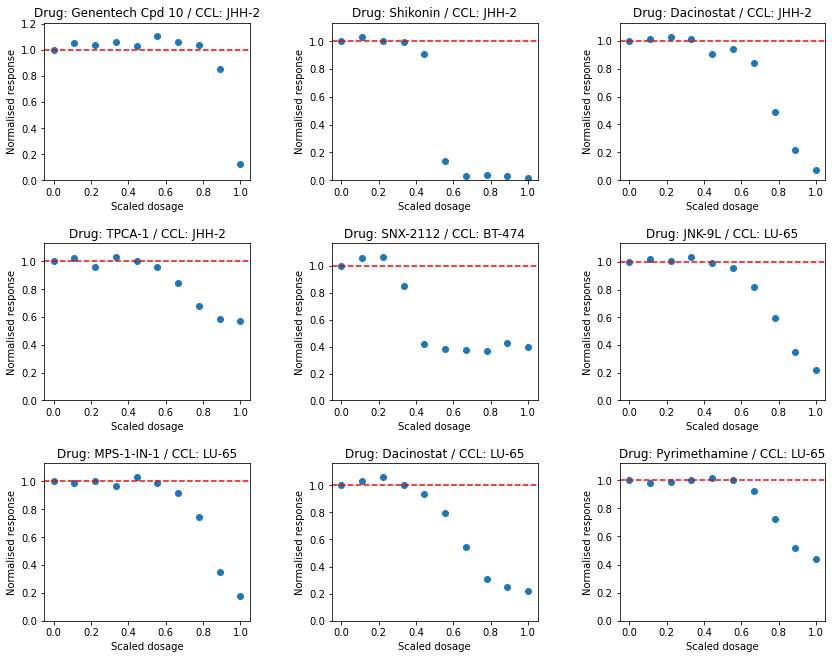

In [9]:
high_resp_data = FindHighResponses(df_sigm, response_norm)
print("Responses above 1:", high_resp_data.shape[0])

df = high_resp_data
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


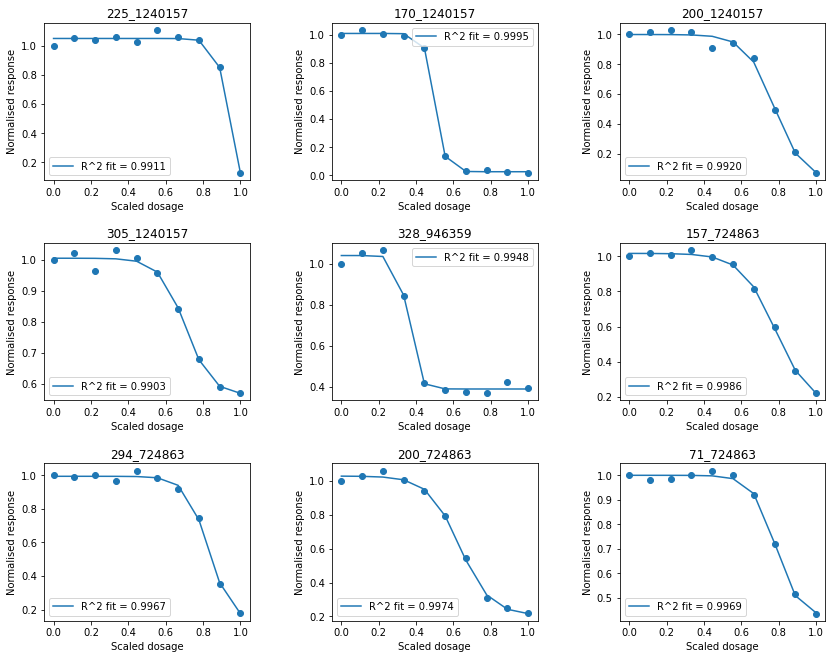

In [10]:
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = "sigmoid_4_param", 
                                  fitting_parameters = "sigmoid_4_param")

Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


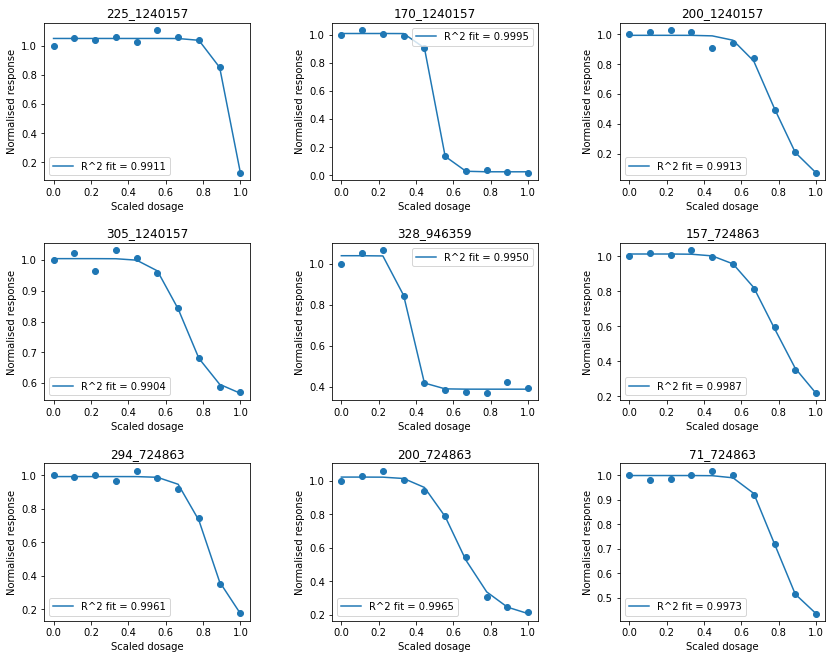

In [11]:
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = "ll4_4_param", 
                                  fitting_parameters = "ll4_4_param")

## Bad data left after fitting with sigmoid_4_param

Ascending points: 3


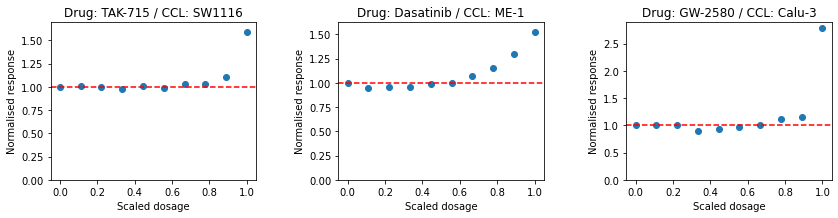

In [12]:
ascend_data = FindAscendingData(df_sigm, response_norm, middle_points_limit=-0.2)
print("Ascending points:", ascend_data.shape[0])

df = ascend_data
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


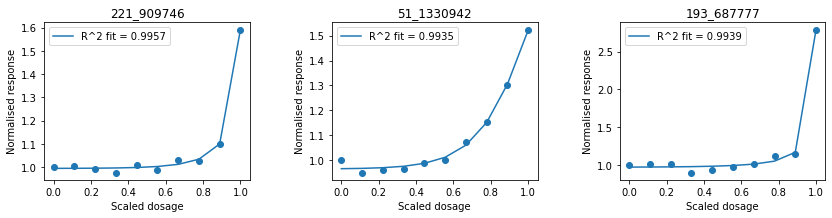

In [13]:
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = "sigmoid_4_param", 
                                  fitting_parameters = "sigmoid_4_param")

## ll4_param

Responses above 1: 5339


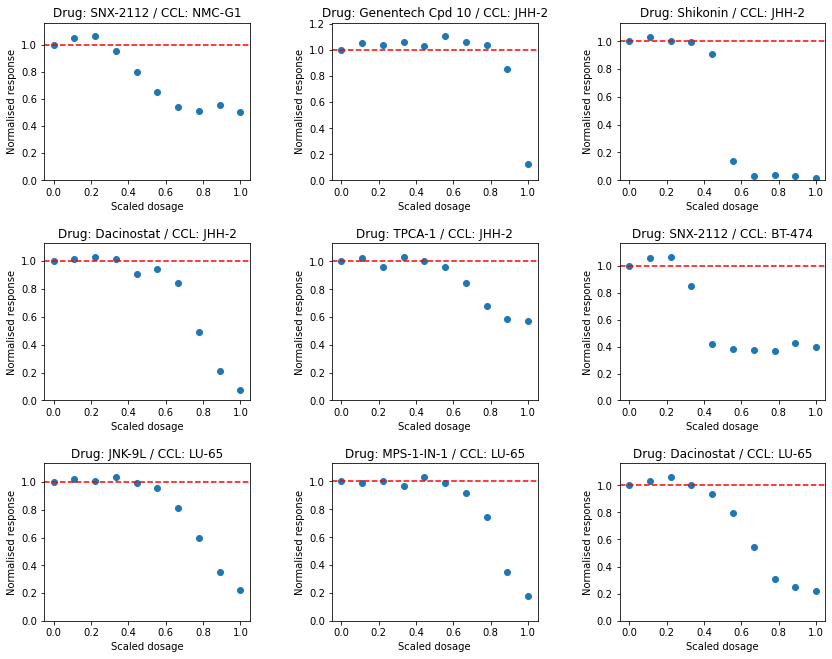

In [14]:
high_resp_data = FindHighResponses(df_ll, response_norm)
print("Responses above 1:", high_resp_data.shape[0])

df = high_resp_data
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Bad data left after fitting with ll4_4_param

Ascending points: 4


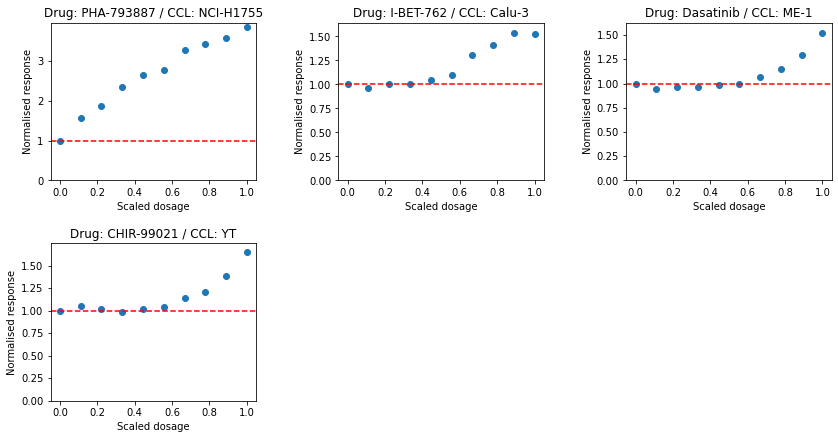

In [15]:
ascend_data = FindAscendingData(df_ll, response_norm, middle_points_limit=-0.2)
print("Ascending points:", ascend_data.shape[0])

df = ascend_data
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


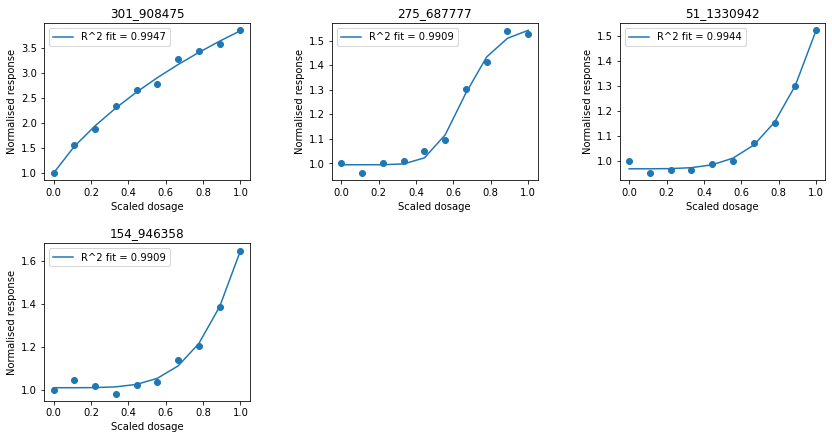

In [16]:
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = "ll4_4_param", 
                                  fitting_parameters = "ll4_4_param")

## LL4 fitting covers more data. But does df_ll include df_sigm?

In [17]:
len(set(df_sigm.index)&set(df_ll.index))

13510

In [18]:
df_sigm.shape[0]

15166

In [19]:
df_sigm_2 = no_filt[(no_filt["sigmoid_4_param_r2"]>=0.97)& (no_filt["sigmoid_4_param_r2"]<0.99)].copy()
df_ll_2 = no_filt[(no_filt["sigmoid_4_param_r2"]>=0.97)& (no_filt["sigmoid_4_param_r2"]<0.99)].copy()
print(df_sigm.shape[0], df_sigm_2.shape[0])

15166 17873


Ascending points: 215
Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


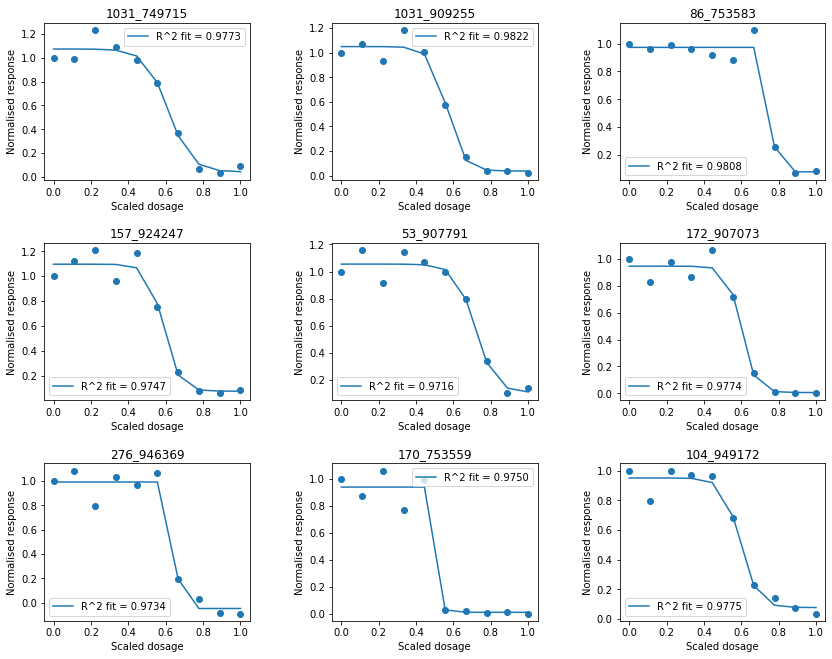

In [20]:
ascend_data = FindAscendingData(df_sigm_2, response_norm, middle_points_limit=-0.2)
print("Ascending points:", ascend_data.shape[0])

df = ascend_data
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                        indexes=df.index[:9],fitting_function = "sigmoid_4_param", 
                                  fitting_parameters = "sigmoid_4_param")

## Drugs with more than 10 profiles

In [21]:
df_sigm.columns

Index(['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID',
       'FOLD_DILUTION', 'MAX_CONC', 'fd_num_0', 'fd_num_1', 'fd_num_2',
       'fd_num_3', 'fd_num_4', 'fd_num_5', 'fd_num_6', 'fd_num_7', 'fd_num_8',
       'fd_num_9', 'norm_cells_0', 'norm_cells_1', 'norm_cells_2',
       'norm_cells_3', 'norm_cells_4', 'norm_cells_5', 'norm_cells_6',
       'norm_cells_7', 'norm_cells_8', 'norm_cells_9', 'per_slope_change_0',
       'per_slope_change_1', 'per_slope_change_2', 'per_slope_change_3',
       'per_slope_change_4', 'per_slope_change_5', 'per_slope_change_6',
       'per_slope_change_7', 'slope_0', 'slope_1', 'slope_2', 'slope_3',
       'slope_4', 'slope_5', 'slope_6', 'slope_7', 'slope_8', 'fsigmoid_r2',
       'fsigmoid', 'sigmoid_2_param_r2', 'sigmoid_2_param',
       'sigmoid_3_param_r2', 'sigmoid_3_param', 'sigmoid_4_param_r2',
       'sigmoid_4_param', 'logistic_4_param_r2', 'logistic_4_param',
       'll4_4_param_r2', 'll4_4_param', 'll4R_4_param_r2', 'll4R_4_para

In [22]:
df_agg = df_sigm.groupby("DRUG_ID").agg(count = ("COSMIC_ID", "count"))
d = df_agg[df_agg["count"]>=10]
print("Sigmoid_4_param, fitting>0.99")
print("Number of drugs:", d.shape[0])
print("Number of available profiles:", d["count"].sum())

Sigmoid_4_param, fitting>0.99
Number of drugs: 149
Number of available profiles: 14952


In [23]:
df_agg = df_ll.groupby("DRUG_ID").agg(count = ("COSMIC_ID", "count"))
d = df_agg[df_agg["count"]>=10]
print("ll4_4_param, fitting>0.99")
print("Number of drugs:", d.shape[0])
print("Number of available profiles:", d["count"].sum())

ll4_4_param, fitting>0.99
Number of drugs: 158
Number of available profiles: 16902
